- gender : male
- number of siblings: siblings
- index of family involvement: family_inv
- primary household language is not english: non_english
- presence of previous disability: prev_disab
- non-white race: non_white
- age at time of testing in months: age_test
- hearing loss is not severe: non_severe_hl
- whether mother has a high school diploma: mother_hs
- was hearing impairment identified by 3 months of age: early_ident

- outcome variable is a standardized test score of learning domains

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at


%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.1.1


In [2]:
lsl_dr_df = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)

In [3]:
lsl_dr_df.describe().T

,count,mean,std,min,25%,50%,75%,max
score,207.0,84.193237,24.885590,0.0,68.0,87.0,98.0,144.0
male,207.0,0.512077,0.501066,0.0,0.0,1.0,1.0,1.0
siblings,207.0,1.125604,0.866682,0.0,1.0,1.0,2.0,3.0
family_inv,174.0,0.977011,1.002621,0.0,0.0,1.0,2.0,4.0
prev_disab,189.0,0.238095,0.427049,0.0,0.0,0.0,0.0,1.0
age_test,207.0,53.545894,3.631920,48.0,50.0,54.0,57.0,59.0
non_severe_hl,207.0,0.415459,0.493996,0.0,0.0,0.0,1.0,1.0
mother_hs,134.0,0.701493,0.459320,0.0,0.0,1.0,1.0,1.0


In [4]:
text_columns = [ x for x in lsl_dr_df if x not in lsl_dr_df.describe().columns]
for x in text_columns:
    print(lsl_dr_df[x].value_counts())

False    165
True      42
Name: non_english, dtype: int64
False    129
True      78
Name: early_ident, dtype: int64
False    107
True     100
Name: non_white, dtype: int64


In [5]:
lsl_dr_df.isna().sum()

score             0
male              0
siblings          0
family_inv       33
non_english       0
prev_disab       18
age_test          0
non_severe_hl     0
mother_hs        73
early_ident       0
non_white         0
dtype: int64

In [6]:
lsl_dr_df.isna().sum() == 0

score             True
male              True
siblings          True
family_inv       False
non_english       True
prev_disab       False
age_test          True
non_severe_hl     True
mother_hs        False
early_ident       True
non_white         True
dtype: bool

In [7]:
full_pop = [x for x in lsl_dr_df.isna().sum().index if lsl_dr_df.isna().sum()[x]==0]
full_pop

['score',
 'male',
 'siblings',
 'non_english',
 'age_test',
 'non_severe_hl',
 'early_ident',
 'non_white']

In [8]:
X = lsl_dr_df[full_pop].astype(float)
y = X.pop('score')

In [9]:
# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

In [10]:
D0 = int(D / 2)

In [11]:
X.head()

,male,siblings,non_english,age_test,non_severe_hl,early_ident,non_white
0,-1.021976,1.008901,-0.503305,0.400368,1.183292,-0.775713,-0.964399
1,0.973770,-1.298751,-0.503305,-0.150304,-0.841017,-0.775713,-0.964399
2,0.973770,-0.144925,1.977269,-0.425641,1.183292,-0.775713,1.031906
3,-1.021976,2.162727,-0.503305,0.400368,-0.841017,-0.775713,-0.964399
5,-1.021976,-1.298751,-0.503305,-0.976314,-0.841017,-0.775713,-0.964399


In [12]:
with pm.Model(coords = {"predictors":X.columns.values}) as test_score_model:
    sigma = pm.HalfNormal("sigma", 25)
    
    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0/(D-D0)*sigma/np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 2, dims = "predictors")
    c2 = pm.InverseGamma("c2", 1, 0.1)
    z = pm.Normal("z", 0.0, 1.0, dims = "predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau *lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25)
    
    scores = pm.Normal("scores", beta0 + at.dot(X.values,beta), sigma, observed = y.values)

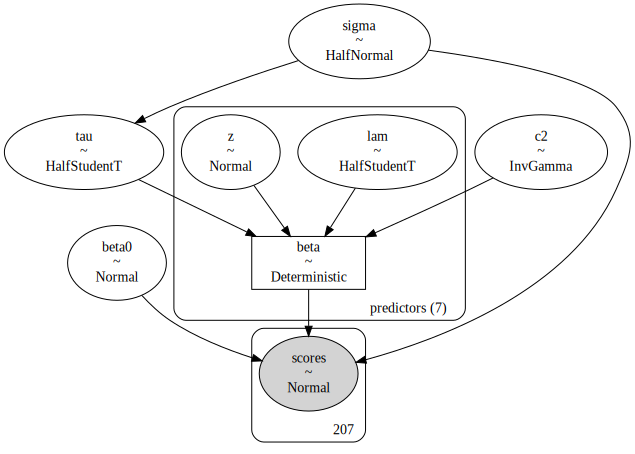

In [13]:
pm.model_to_graphviz(test_score_model)

In [14]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


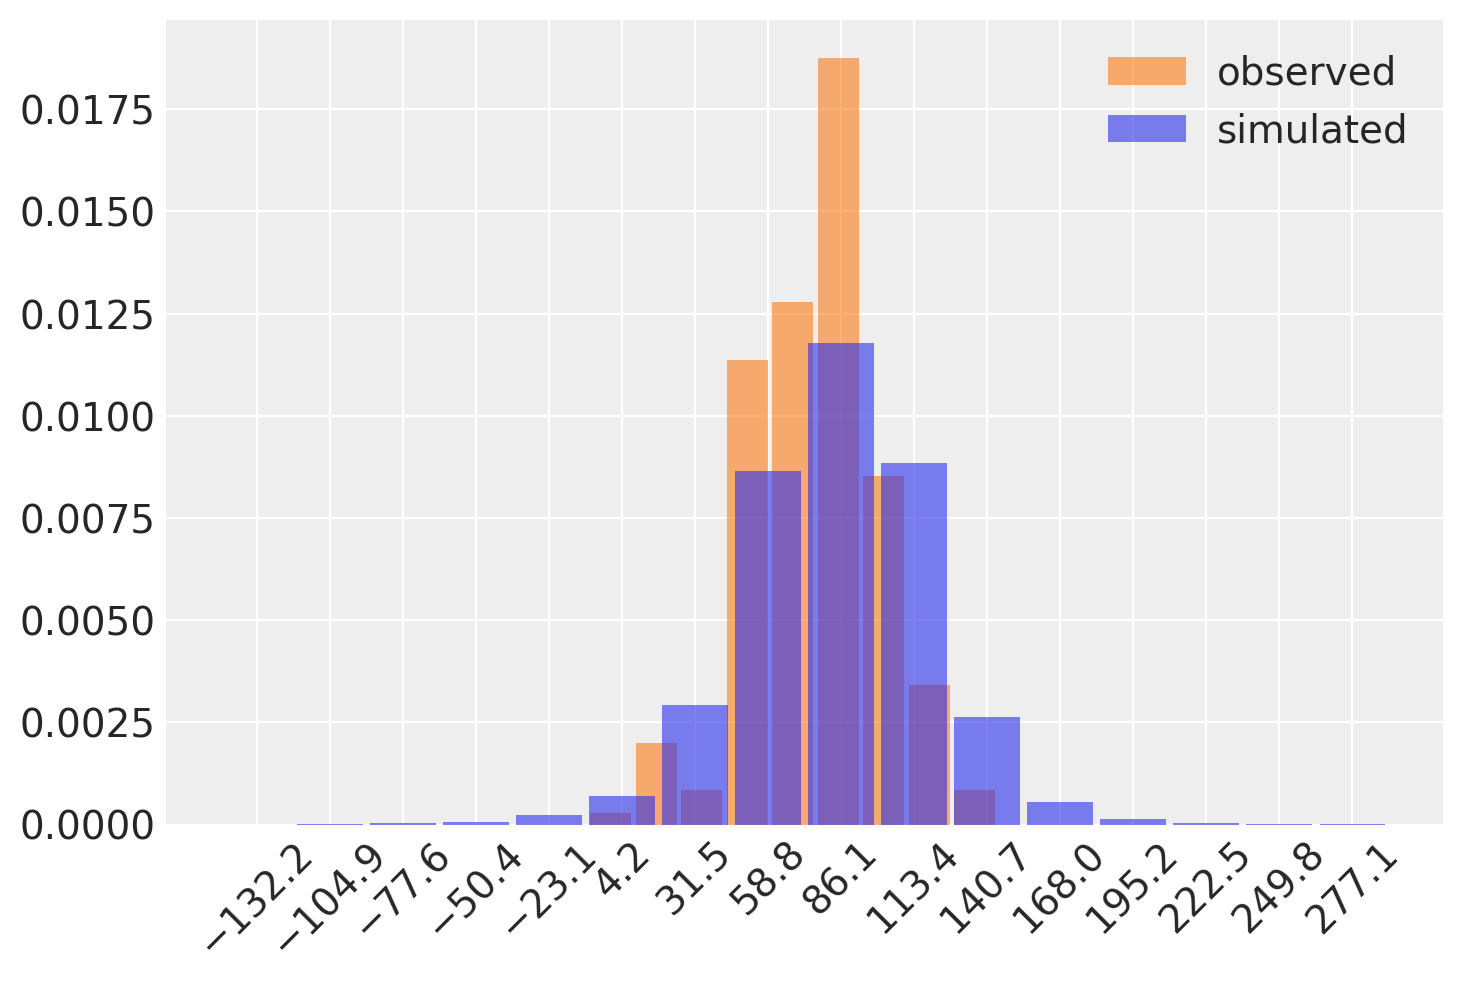

In [15]:
az.plot_dist(
    lsl_dr_df["score"].values,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

In [16]:
with test_score_model:
    idata = pm.sample(1000, tune = 2000, random_seed=42)

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [17]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99)

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 61 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'c2'}>, <Axes: title={'center': 'c2'}>]],
      dtype=object)

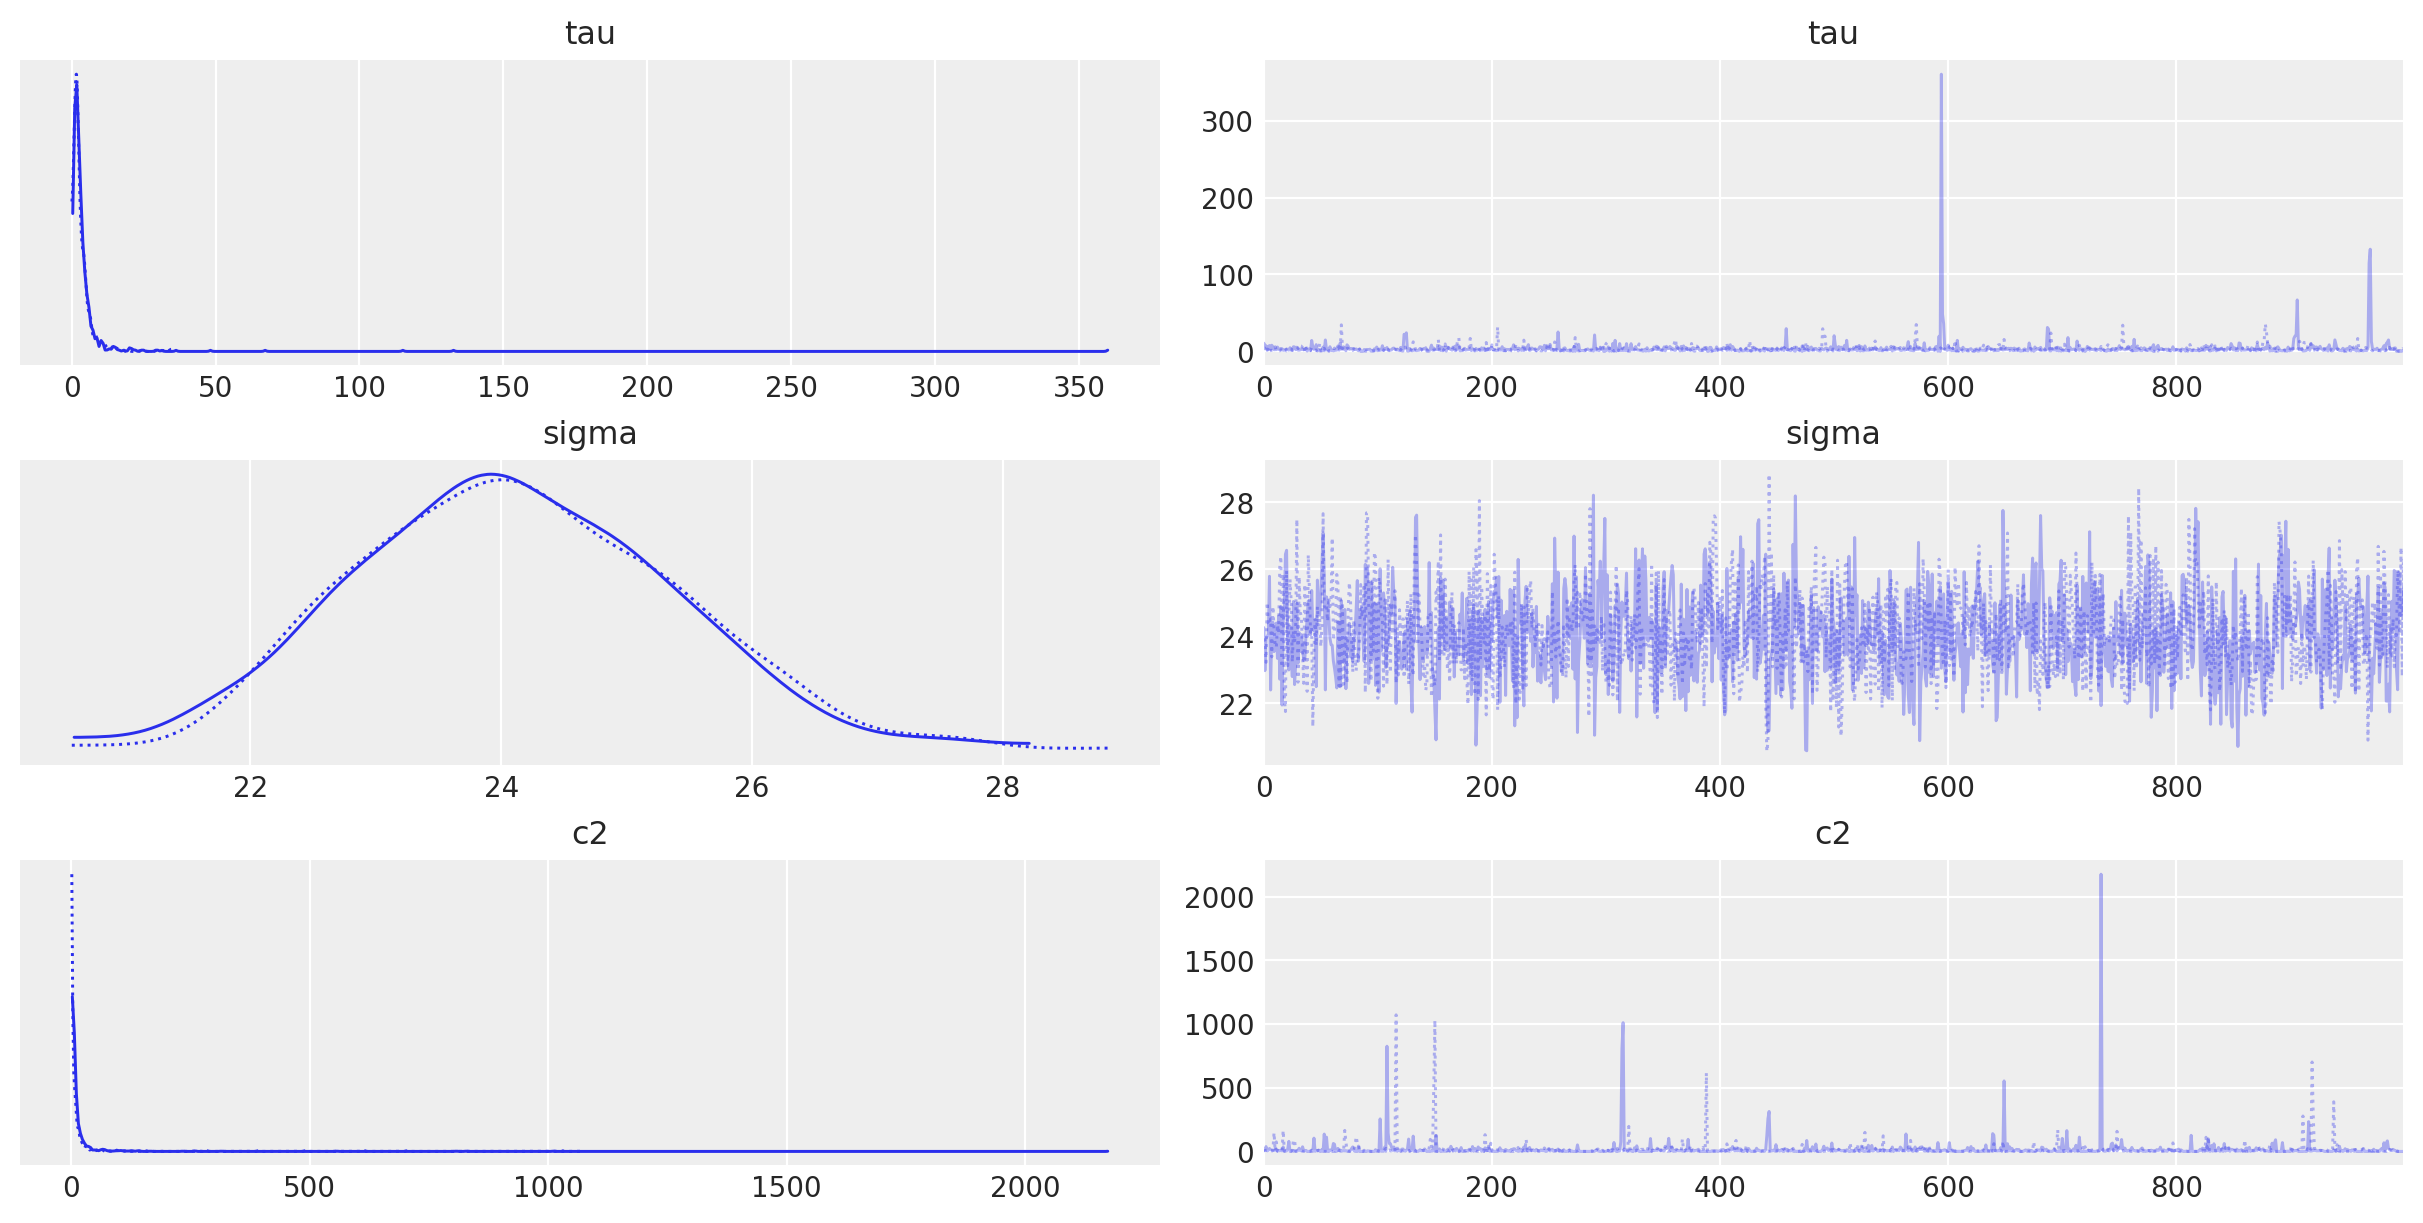

In [18]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"])

<Axes: >

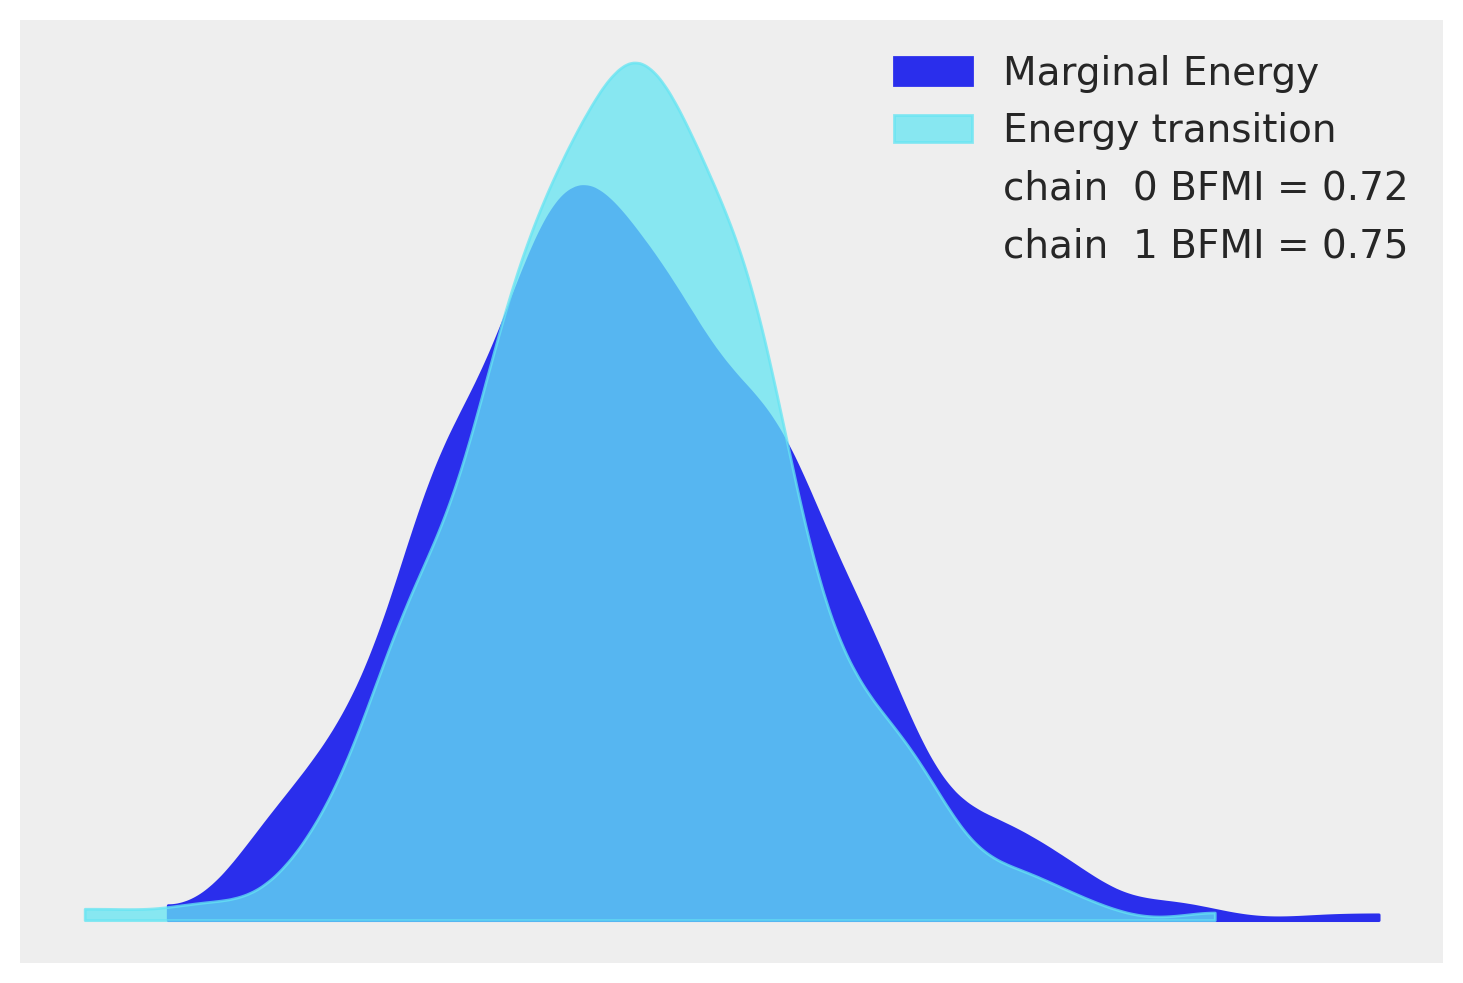

In [19]:
az.plot_energy(idata)

array([<Axes: title={'center': '97.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

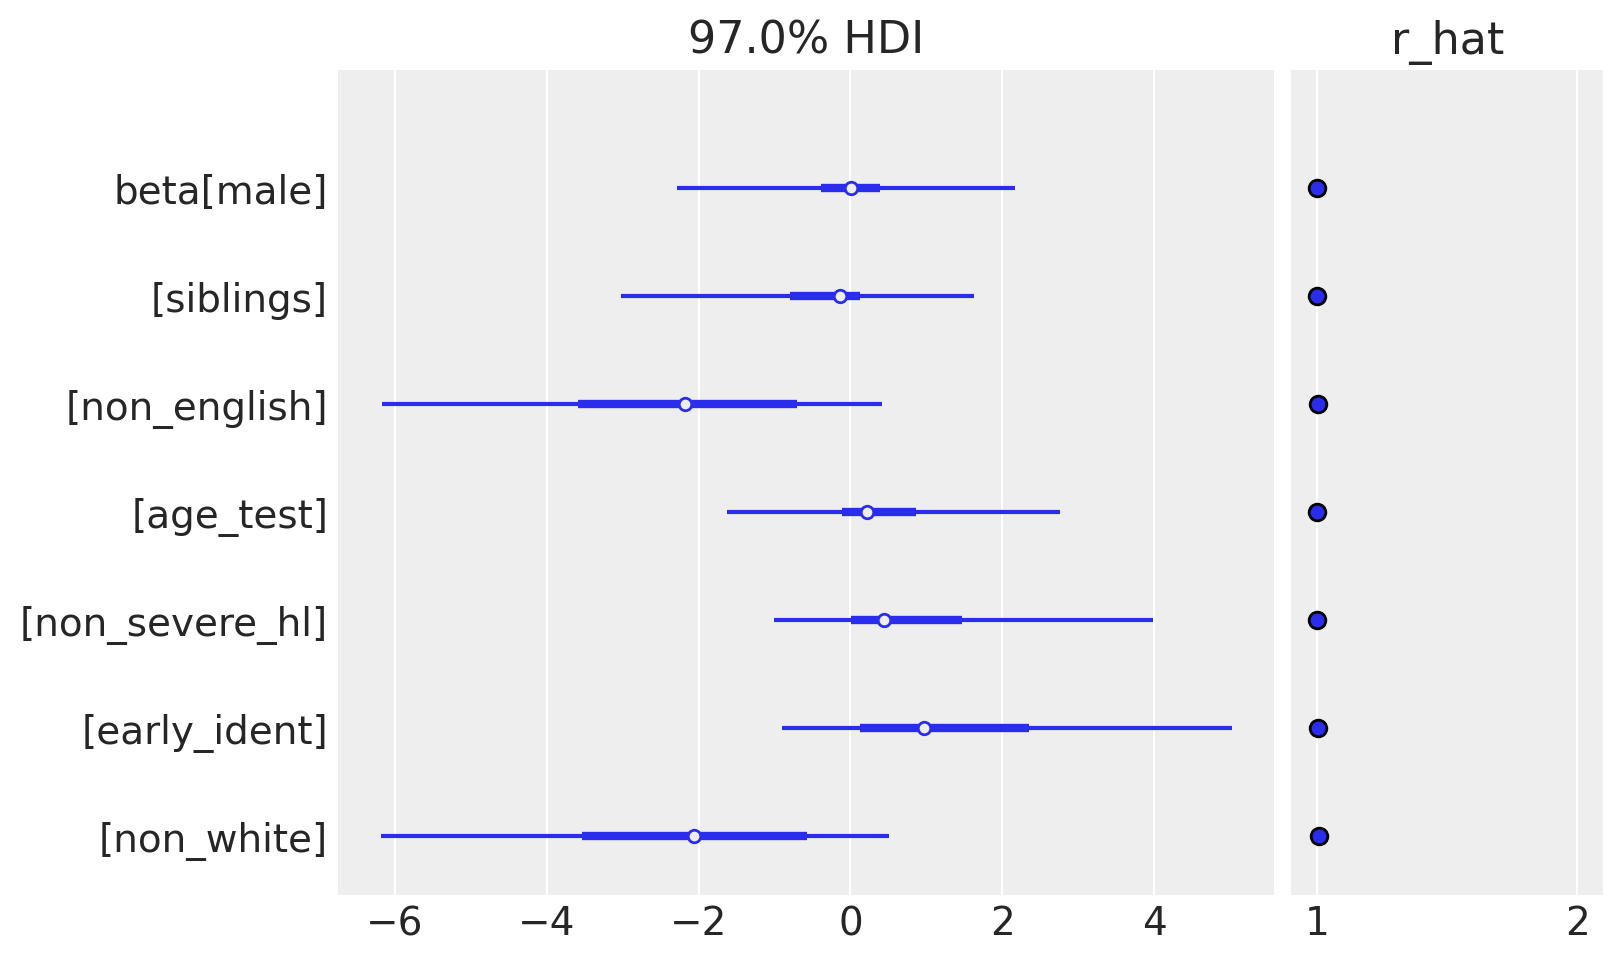

In [20]:
az.plot_forest(idata, var_names = ['beta'], combined=True, hdi_prob=0.97, r_hat=True)

In [21]:
# TODO: Missing values - what to do about them?
# TODO: What about categorical variables - we have modelled these as continuous